In [1]:
! module load cuda/11.8.0

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNet, NeuralNetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm.auto import tqdm, trange
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import joblib
# from helpful_functions import log_transform, log_inverse, CustomLogTansformer
# TO-MAKE IMPORTED: log_transform, model class
from helpful_functions import InputLogTransformer, OutputLogTransformer, build_neural_network, make_datasets, GPUMemoryLogger
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from skorch.probabilistic import GPRegressor

In [4]:
noise=10
identifier="threeEns"
df = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1525000_noise_{noise}_threeEns_.h5', key='df').fillna(0)
dfB = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1155231_noise_{noise}_{identifier}_campaign1.h5', key='df')
input_list = ['Intensity', 'Target Thickness', 'Focal Distance', 'Contrast']
output_list = ['Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy']
df.loc[:, output_list] = df.loc[:, output_list].clip(1e-2, None)
test_df = pd.read_hdf('datasets/fuchs_v5_0_seed-2_test_250000_noise_0_threeEns_.h5', key = 'df').fillna(0)
test_df.loc[:, output_list] = test_df.loc[:, output_list].clip(1e-2, None)
print(list(df.columns))

['Intensity', 'Pulse Duration', 'Target Thickness', 'Spot Size', 'Focal Distance', 'Contrast', 'Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy', 'Max Exact Energy', 'Total Exact Energy', 'Avg Exact Energy', 'Laser Energy', 'Conversion Efficiency']


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class MultitaskSVGPModel(ApproximateGP):
    def __init__(self, inducing_points, num_latents, num_tasks):
        # Let's use a different set of inducing points for each latent function
        #inducing_points = torch.rand(num_latents, 16, 3)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super(MultitaskSVGPModel, self).__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [7]:
X = np.array(df[input_list],dtype=np.float32)
y = np.array(df[output_list],dtype=np.float32)
X_train, y_train, X_val, y_val, input_transformer, output_transformer = make_datasets(X, y, random_state=42)
X_train = torch.tensor(X_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)
X_val = torch.tensor(X_val, device=device, dtype=torch.float32)
y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_val, y_val)
X_test = np.array(test_df[input_list],dtype=np.float32)
y_test = np.array(test_df[output_list],dtype=np.float32)
num_dof = len(X_train)

In [8]:
num_train_samples = len(X_train)
num_inducing = 2000
space_every = int(num_train_samples/num_inducing+0.5)

In [9]:
X_train

tensor([[ 8.6737e-01, -5.2199e-01, -1.1389e-01,  1.0795e+00],
        [ 8.6737e-01,  1.5670e+00, -5.7088e-02,  1.6942e-01],
        [ 7.4969e-01,  1.7434e-01, -2.8078e-04, -8.0029e-02],
        ...,
        [-1.6424e+00,  1.2189e+00, -6.2516e-01,  6.2192e-01],
        [ 1.1197e-01, -5.2199e-01, -1.7045e+00, -1.4797e+00],
        [-1.8265e+00,  1.5670e+00,  1.7039e+00, -1.0641e+00]], device='cuda:0')

In [10]:
model = GPRegressor(
    MultitaskSVGPModel,
    module__inducing_points=X_train[::space_every],
    module__num_tasks=3,
    module__num_latents=8,

    criterion = gpytorch.mlls.VariationalELBO,
    criterion__num_data = y_train.shape[0],

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3),

    optimizer=torch.optim.Adam,
    lr = 0.01,
    batch_size=1024,
    max_epochs=50,
    train_split=predefined_split(valid_ds),
    device=device,

    callbacks=[('early_stopping', EarlyStopping(patience=5,monitor='valid_loss')),('memory_logger', GPUMemoryLogger(verbose=True))]
)

In [11]:
model.fit(train_ds, y=None)

GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1       -0.3124       -1.6890  163.0232
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      2       -1.8629       -1.9057  162.8710
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      3       -2.0094       -2.0158  162.6998
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      4       -2.1006       -2.0931  162.6935
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      5       -2.1652       -2.1380  163.1368
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      6       -2.2092       -2.1727  163.0508
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      7       -2.2391       -2.1847  163.2201
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      8       -2.2619       -2.2225  162.7897
GPU memory usage: 5298.00 MB
Available memory: 76622.00 MB
      9  

<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=MultitaskSVGPModel(
    (variational_strategy): LMCVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

In [12]:
del X, X_train, X_val, y, y_train, y_val, train_ds, valid_ds
torch.cuda.empty_cache()

In [13]:
# y_pred = output_transformer.inverse_transform(model.predict(X_val))
# y_pred_lower, y_pred_upper = model.confidence_region(X_val)
# y_pred_lower = output_transformer.inverse_transform(y_pred_lower.cpu().detach().numpy())
# y_pred_upper = output_transformer.inverse_transform(y_pred_upper.cpu().detach().numpy())
# y_train_pred = output_transformer.inverse_transform(model.predict(X_train))
#y_train_pred_lower, y_train_pred_upper = model.confidence_region(X_train)
#y_train_pred_lower = output_transformer.inverse_transform(y_train_pred_lower.cpu().detach().numpy())
#y_train_pred_upper = output_transformer.inverse_transform(y_train_pred_upper.cpu().detach().numpy())

In [14]:
X_test_scaled = torch.tensor(input_transformer.transform(X_test), device=device, dtype=torch.float32)
y_test_pred = output_transformer.inverse_transform(model.predict(X_test_scaled))
#y_test_pred_lower, y_test_pred_upper = model.confidence_region(X_test_scaled)
#y_test_pred_lower = output_transformer.inverse_transform(y_test_pred_lower.cpu().detach().numpy())
#y_train_pred_upper = output_transformer.inverse_transform(y_test_pred_upper.cpu().detach().numpy())
y_test_pred

array([[4.75173831e-01, 1.43885280e+08, 6.73758313e-02],
       [4.86120358e-02, 1.79684100e+06, 1.26146702e-02],
       [3.89349818e-01, 1.16049408e+08, 7.87394792e-02],
       ...,
       [3.44640076e-01, 4.98697920e+07, 6.80105463e-02],
       [5.57489038e-01, 1.08611336e+08, 9.29342210e-02],
       [1.61087468e-01, 2.35687760e+07, 3.40853631e-02]], dtype=float32)

In [15]:
print("Model performance on blind randomized testing data:", mean_absolute_percentage_error(y_test, y_test_pred)*100)

Model performance on blind randomized testing data: 3.1704142689704895


In [16]:
del X_test_scaled, y_test_pred,
torch.cuda.empty_cache()

Text(0, 0.5, 'Max Proton Energy (MeV)')

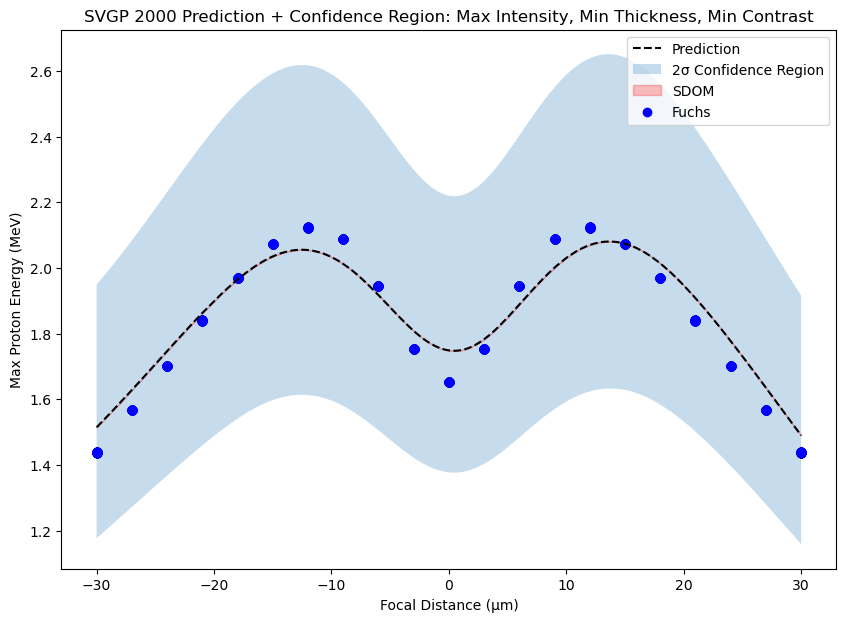

In [17]:
dfB = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1155231_noise_10_threeEns_campaign1.h5', key='df')
thickness = 0.5
#X_coord = preddf["Focus"].to_numpy()
#y_coord = preddf["Max"].to_numpy()
intensity = 1e19
dx = 0.005
dI = 1e16
contrast = 1e-7
dC = 1e-9
focus_dip = np.linspace(-30, 30, 1000)
intens_dip = np.ones(1000)*intensity
thickness_dip = np.ones(1000)*thickness
contrast_dip = np.ones(1000)*contrast

dip_params = np.array([intens_dip, thickness_dip, focus_dip, contrast_dip], dtype=np.float32).T

dip_params_scaled = input_transformer.transform(dip_params)
dip_preds = output_transformer.inverse_transform(model.predict(dip_params_scaled))
dip_lower, dip_upper = model.confidence_region(dip_params_scaled)
dip_lower = output_transformer.inverse_transform(dip_lower.cpu().detach().numpy())
dip_upper = output_transformer.inverse_transform(dip_upper.cpu().detach().numpy())
max_dip = dip_preds[:, 0]
max_lower = dip_lower[:, 0]
max_upper = dip_upper[:, 0]
max_SDOM_upper = (max_upper - max_dip)/np.sqrt(num_dof) + max_dip
max_SDOM_lower = max_dip - (max_dip-max_lower)/np.sqrt(num_dof)
exactdf = dfB[(dfB["Target Thickness"]>thickness-dx) & (dfB["Target Thickness"] < thickness+dx) & (dfB["Intensity"]<intensity+dI) & (dfB["Intensity"] > intensity-dI)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
#exactdf = df[(df["Target Thickness"]>thickness-dx) & (df["Target Thickness"] < thickness+dx) & (df["Intensity"]<intensity+dI) & (df["Intensity"] > intensity-dI) & (df["Contrast"] > contrast-dC) & (df["Contrast"] < contrast+dC)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
#exactdf = test_df[(test_df["Target Thickness"]==thickness) & (test_df["Intensity"]==1e19)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
# y_pred0_corrected = np.zeros_like(dip_preds)
# for i in range(len(correction_factors)):
#     y_pred0_corrected[:, i] = dip_preds[:, i] * correction_factors[i]
#if GPU:
#    y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(X0).get().reshape(-1, 1), modelB.predict(X0).get().reshape(-1, 1), modelC.predict(X0).get().reshape(-1, 1)), axis=1))
#if CPU:
#   y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(poly.transform(X0)).reshape(-1, 1), modelB.predict(poly.transform(X0)).reshape(-1, 1), modelC.predict(poly.transform(X0)).reshape(-1, 1)), axis=1))
X_exact = exactdf["Focal Distance"].to_numpy()
y_exact = exactdf["Max Exact Energy"].to_numpy()
y_noisy = exactdf["Max Proton Energy"].to_numpy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
ax.plot(focus_dip, max_dip, color='black', linestyle='--',label='Prediction')
#ax.plot(focus_dip, y_pred0_corrected[:, 0], linestyle='--',color='red',label='Corrected Prediction')
ax.fill_between(focus_dip, max_lower, max_upper, label="2σ Confidence Region", alpha=0.25)
ax.fill_between(focus_dip, max_SDOM_lower, max_SDOM_upper, label="SDOM", color="red", alpha=0.25)
#ax.scatter(preddf2['Focus'], preddf2['Max'], c=preddf2["color"],marker="*",label='Testing')
#ax.scatter(X_coord, y_coord,color=colors)
ax.scatter(X_exact,y_exact, color='blue',label="Fuchs")
#ax.scatter(X_exact,y_noisy, color='green',marker="^",label="Noisy Fuchs")
ax.legend(loc='upper right')
ax.set_title(f"SVGP {num_inducing} Prediction + Confidence Region: Max Intensity, Min Thickness, Min Contrast")
ax.set_xlabel("Focal Distance (μm)")
ax.set_ylabel("Max Proton Energy (MeV)")

In [18]:
len(focus_dip)

1000

In [19]:
model.callbacks[-1][-1].get_memory_usage()

[5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0,
 5298.0]

In [20]:
from datetime import datetime
stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"results/GP_{stamp}.png")

In [21]:
import joblib
from datetime import datetime
stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_name = "SVGP " + stamp + ".pth"
likelihood_name = "Likelihood " + stamp + ".pth"
out_name = "Output Transformer " + stamp + ".sav"
in_name = "Input Transformer " + stamp + ".sav"

torch.save(model.module_.state_dict(), model_name)
torch.save(model.likelihood_.state_dict(), likelihood_name)
joblib.dump(input_transformer, in_name)
joblib.dump(output_transformer, out_name)

['Output Transformer 2024-07-19-16-35-26.sav']

In [22]:
model2 = GPRegressor(
    MultitaskSVGPModel,
    module__num_tasks=3,
    module__num_latents=8,
    module__inducing_points = torch.rand(2000, 4),
    
    criterion = gpytorch.mlls.VariationalELBO,
    criterion__num_data = 100,
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3),
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)
model2.initialize()

<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=MultitaskSVGPModel(
    (variational_strategy): LMCVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

In [23]:
model2.module_.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [24]:
model2.likelihood_.load_state_dict(torch.load(likelihood_name))

<All keys matched successfully>

Text(0, 0.5, 'Max Proton Energy (MeV)')

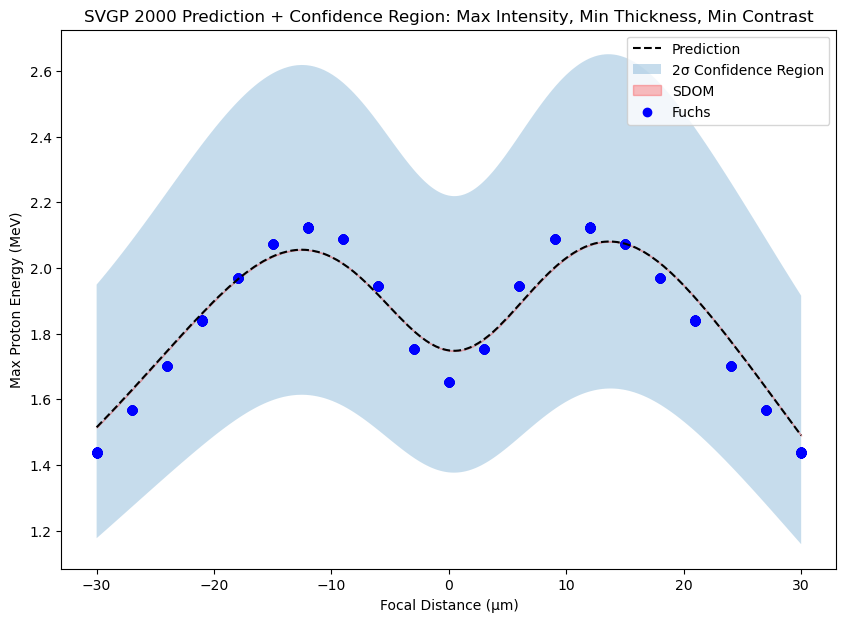

In [25]:
dfB = pd.read_hdf(f'datasets/fuchs_v5_0_seed-2_train_1155231_noise_10_threeEns_campaign1.h5', key='df')
thickness = 0.5
#X_coord = preddf["Focus"].to_numpy()
#y_coord = preddf["Max"].to_numpy()
intensity = 1e19
dx = 0.005
dI = 1e16
contrast = 1e-7
dC = 1e-9
focus_dip = np.linspace(-30, 30, 1000)
intens_dip = np.ones(1000)*intensity
thickness_dip = np.ones(1000)*thickness
contrast_dip = np.ones(1000)*contrast

dip_params = np.array([intens_dip, thickness_dip, focus_dip, contrast_dip], dtype=np.float32).T

dip_params_scaled = input_transformer.transform(dip_params)
dip_preds = output_transformer.inverse_transform(model2.predict(dip_params_scaled))
dip_lower, dip_upper = model2.confidence_region(dip_params_scaled)
dip_lower = output_transformer.inverse_transform(dip_lower.cpu().detach().numpy())
dip_upper = output_transformer.inverse_transform(dip_upper.cpu().detach().numpy())
max_dip = dip_preds[:, 0]
max_lower = dip_lower[:, 0]
max_upper = dip_upper[:, 0]
max_SDOM_upper = (max_upper - max_dip)/np.sqrt(num_dof) + max_dip
max_SDOM_lower = max_dip - (max_dip-max_lower)/np.sqrt(num_dof)
exactdf = dfB[(dfB["Target Thickness"]>thickness-dx) & (dfB["Target Thickness"] < thickness+dx) & (dfB["Intensity"]<intensity+dI) & (dfB["Intensity"] > intensity-dI)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
#exactdf = df[(df["Target Thickness"]>thickness-dx) & (df["Target Thickness"] < thickness+dx) & (df["Intensity"]<intensity+dI) & (df["Intensity"] > intensity-dI) & (df["Contrast"] > contrast-dC) & (df["Contrast"] < contrast+dC)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
#exactdf = test_df[(test_df["Target Thickness"]==thickness) & (test_df["Intensity"]==1e19)].drop_duplicates(subset=["Target Thickness", "Focal Distance", "Intensity"]).sort_values(by="Focal Distance")
# y_pred0_corrected = np.zeros_like(dip_preds)
# for i in range(len(correction_factors)):
#     y_pred0_corrected[:, i] = dip_preds[:, i] * correction_factors[i]
#if GPU:
#    y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(X0).get().reshape(-1, 1), modelB.predict(X0).get().reshape(-1, 1), modelC.predict(X0).get().reshape(-1, 1)), axis=1))
#if CPU:
#   y_pred0 = output_transformer.inverse_transform(np.concatenate((modelA.predict(poly.transform(X0)).reshape(-1, 1), modelB.predict(poly.transform(X0)).reshape(-1, 1), modelC.predict(poly.transform(X0)).reshape(-1, 1)), axis=1))
X_exact = exactdf["Focal Distance"].to_numpy()
y_exact = exactdf["Max Exact Energy"].to_numpy()
y_noisy = exactdf["Max Proton Energy"].to_numpy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
ax.plot(focus_dip, max_dip, color='black', linestyle='--',label='Prediction')
#ax.plot(focus_dip, y_pred0_corrected[:, 0], linestyle='--',color='red',label='Corrected Prediction')
ax.fill_between(focus_dip, max_lower, max_upper, label="2σ Confidence Region", alpha=0.25)
ax.fill_between(focus_dip, max_SDOM_lower, max_SDOM_upper, label="SDOM", color="red", alpha=0.25)
#ax.scatter(preddf2['Focus'], preddf2['Max'], c=preddf2["color"],marker="*",label='Testing')
#ax.scatter(X_coord, y_coord,color=colors)
ax.scatter(X_exact,y_exact, color='blue',label="Fuchs")
#ax.scatter(X_exact,y_noisy, color='green',marker="^",label="Noisy Fuchs")
ax.legend(loc='upper right')
ax.set_title(f"SVGP {num_inducing} Prediction + Confidence Region: Max Intensity, Min Thickness, Min Contrast")
ax.set_xlabel("Focal Distance (μm)")
ax.set_ylabel("Max Proton Energy (MeV)")

In [26]:
df.loc[:, output_list].clip(1, None)

,Max Proton Energy,Total Proton Energy,Avg Proton Energy
0,1.0,2.948299e+07,1.0
1,1.0,2.777022e+07,1.0
2,1.0,2.069793e+07,1.0
3,1.0,2.787228e+07,1.0
4,1.0,1.839270e+07,1.0
...,...,...,...
1524995,1.0,3.413159e+07,1.0
1524996,1.0,3.438792e+07,1.0
1524997,1.0,3.444866e+07,1.0
1524998,1.0,3.116040e+07,1.0
